In [18]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import cv2

# Load the decoder model
decoder = load_model('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_April16.h5')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
import os
import cv2
from sklearn.model_selection import train_test_split

def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
            img = img[:,:,::-1]
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/process_images"
x_data = load_images(folder_path)
x_data.shape

(2518, 64, 64, 3)

In [20]:
import tensorflow as tf
import numpy as np

dataset = tf.data.Dataset.from_tensor_slices(x_data)

# Set the batch size
BATCH_SIZE = 128
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [21]:
def denormalize(image):
    return image

def display_image(image):
    denorm_image = denormalize(image)
    plt.imshow(denorm_image)
    plt.axis('off')
    plt.show()

def display_batch(images, title):
    fig = plt.figure(figsize=(6, 6))
    plt.suptitle(title)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Dense, Flatten,LeakyReLU,Conv2D,Activation


LATENT_DIM = 256
NOISE_DIM = 512
IMAGE_SIZE = 64

def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.keras.backend.random_normal(shape=(batch_size, LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def generator(decoder, noise_dim=NOISE_DIM):
    """
    Generate image from noise 
    Inputs:
    - decoder: pretrain model for genrate image freom mean and std
    - noise_dim: the dimension of the noise 
    
    Returns:
    TensorFlow Tensor with shape [number of image in one batch, 64, 64, 3]
    """

    # Freeze layers in the saved model
    for i, layer in enumerate(decoder.layers):

        # Check layers
        if i <= (len(decoder.layers) - 0.3 * len(decoder.layers)):
          layer.trainable = True
        else:
          layer.trainable = True
        
        layer._name = f'saved_model_{i}_{layer.name}'


    model = Sequential([
        tf.keras.Input(shape=noise_dim),
        tf.keras.layers.Reshape((16, 16, 2)),
        tf.keras.layers.Conv2D(32, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Dropout(0.25),
        Flatten(),
        Dense(256, input_dim=noise_dim, activation=LeakyReLU()),
        Dense(512, activation=LeakyReLU()),
        Dense(512, activation=LeakyReLU()),
        Lambda(lambda x: sampling([x[:, :256], x[:, 256:]]))
    ])
    
    # Add layers from the saved model
    for layer in decoder.layers:
        model.add(layer)

    model.add(Activation('tanh'))

    return model

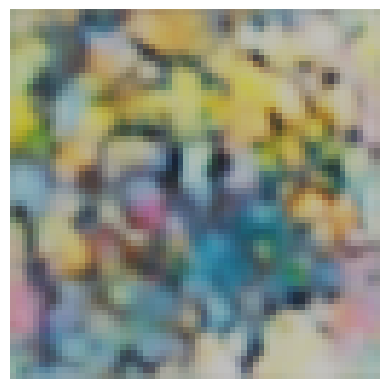

In [23]:
generator_model = generator(decoder)
noise_example = np.random.rand(2, NOISE_DIM) # suppose 2 images in one batch
output_fake = generator_model(noise_example) 

# Let's check the image
output_reshape = output_fake.numpy()#.reshape(-1,64,64,3)
display_image(output_reshape[0])

In [24]:
generator_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 16, 16, 2)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 32)        608       
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_22 (Dense)            (None, 256)              

In [25]:
def discriminator(input_shape=(64,64,3)):
  
    """Compute discriminator score for a batch of input images.
      
    Inputs:
    - x: tensor, shape [number of images in one batch, 64, 64, 3]
    
    Returns:
    TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Reshape((IMAGE_SIZE,IMAGE_SIZE,3), input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape = input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator_model = discriminator()

In [26]:
discriminator_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 256)         295168    
                                                      

In [27]:
# construct discriminator loss
def generator_loss(fake_score):
    """
    Input:
    fake_score is the result from discriminator, which is a [number of images in one batch, 1] tensor

    Returns:
    output the distance between fake_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    output is a 1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    # We need our generator loss as close as possible to 1, since 1 represent we fool the discrimiator.
    target = tf.ones_like(fake_score) # Tensor that contan batch_size number of 1. 
    loss = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target,fake_score)
    return loss


def disciminator_loss(fake_score,real_score):
    """
    Input
    fake_score is the result from discriminator by judging the fake image, which is a batch_size * 1 tensor
    real_score is the result from discriminator by judging the real image, which is a batch_size * 1 tensor

    Returns:
    the distance between fake_score and all 0 [number of images in one batch, 1] tebsor by using BinaryCrossentropy
    +  the distance between real_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    =  1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    target_real = tf.ones_like(real_score)
    loss_real = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_real,real_score)

    target_fake = tf.zeros_like(fake_score)
    loss_fake = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_fake,fake_score)

    return loss_real + loss_fake


In [31]:
import tensorflow as tf

initial_learning_rate_generator = 8e-6
initial_learning_rate_discriminator = 6e-6
decay_steps = 1000
decay_rate_generator = 0.95
decay_rate_discriminator = 0.90

lr_schedule_generator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_generator,
    decay_steps=decay_steps,
    decay_rate=decay_rate_generator,
    staircase=True
)

lr_schedule_discriminator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_discriminator,
    decay_steps=decay_steps,
    decay_rate=decay_rate_discriminator,
    staircase=True
)

In [32]:
@tf.function
def train_step(real_images,generator_model,discriminator_model,generator_optimizor,discriminator_optimizor):
    """
    Input
    real_images: All images in one batch
    generator_model: generator model, we declear outside generator = generator()
    discriminator_model: discriminator model, we declear outside discriminator = discriminator()
    generator_optimizor: generator_optimizor for generator
    discriminator_optimizor: discriminator_optimizor for discriminator

    Returns:
    the distance between fake_score and all 0 [number of images in one batch, 1] tebsor by using BinaryCrossentropy
    +  the distance between real_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    =  1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    # real_images.shape[0] represent the number of images in one batch
    noise = tf.random.normal([real_images.shape[0], NOISE_DIM])

    # Observe from tensorflow document
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

      # generate images: [number of images in one batch, 64 * 64 * 3] tensor
      fake_images = generator_model(noise, training=True)

      # Reshape images
      # fake_images = tf.reshape(fake_images,(-1,64,64,3))
      # real_images = tf.reshape(real_images,(-1,64,64,3))

      # calculate the score of fake_images and real_images: [number of images in one batch, 1] tensor
      fake_score = discriminator_model(fake_images, training=True)
      real_score = discriminator_model(real_images, training=True)

      # calculate the loss
      generator_loss_value = generator_loss(fake_score)
      # print(generator_loss_value)
      disciminator_loss_value = disciminator_loss(fake_score,real_score)
    
    # Update the weights of the model to minimize the loss value.
    generator_gradients = gen_tape.gradient(generator_loss_value, generator_model.trainable_weights)
    disciminator_gradients = dis_tape.gradient(disciminator_loss_value, discriminator_model.trainable_weights)

    generator_optimizor.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
    discriminator_optimizor.apply_gradients(zip(disciminator_gradients, discriminator_model.trainable_weights))

    return generator_loss_value,disciminator_loss_value,fake_images,fake_score,real_score


def train_gan(dataset, generator, discriminator, epochs):
    generator_optimizer = tf.keras.optimizers.Adam(lr_schedule_generator)
    discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule_discriminator)

    for epoch in range(epochs):
        gen_loss_sum = 0
        disc_loss_sum = 0
        num_batches = 0
        fake_score_sum = 0
        real_score_sum = 0

        for image_batch in dataset:
            gen_loss, disc_loss,fake_images,fake_score,real_score = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            gen_loss_sum += gen_loss
            disc_loss_sum += disc_loss
            num_batches += 1
            fake_score_sum += np.mean(fake_score.numpy())
            real_score_sum += np.mean(real_score.numpy())

        if epoch % 5 == 0:
          generated_images = fake_images.numpy()[0:9]
          denorm_images = [denormalize(img) for img in generated_images]
          display_batch(denorm_images, f"Generated images at epoch {epoch + 1}")

        
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_sum/num_batches}, fake score: {fake_score_sum/num_batches}, Discriminator Loss: {disc_loss_sum/num_batches}, real score: {real_score_sum/num_batches}')



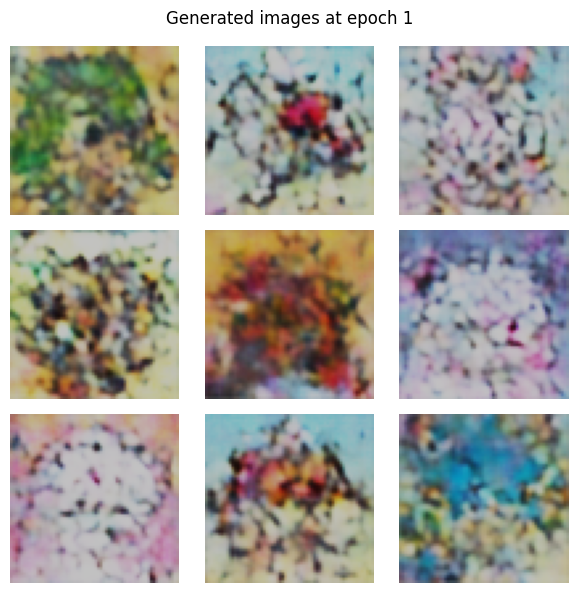

Epoch 1, Generator Loss: 0.7531752586364746, fake score: 0.5079324468970299, Discriminator Loss: 1.5397597551345825, real score: 0.5117171883583069
Epoch 2, Generator Loss: 0.880476176738739, fake score: 0.44972791224718095, Discriminator Loss: 1.3165466785430908, real score: 0.5464544892311096
Epoch 3, Generator Loss: 0.8544986844062805, fake score: 0.45657437592744826, Discriminator Loss: 1.297366738319397, real score: 0.560542544722557
Epoch 4, Generator Loss: 0.918352484703064, fake score: 0.4286404252052307, Discriminator Loss: 1.225906491279602, real score: 0.561676812171936
Epoch 5, Generator Loss: 1.0476305484771729, fake score: 0.3876762524247169, Discriminator Loss: 1.0710076093673706, real score: 0.6060921669006347


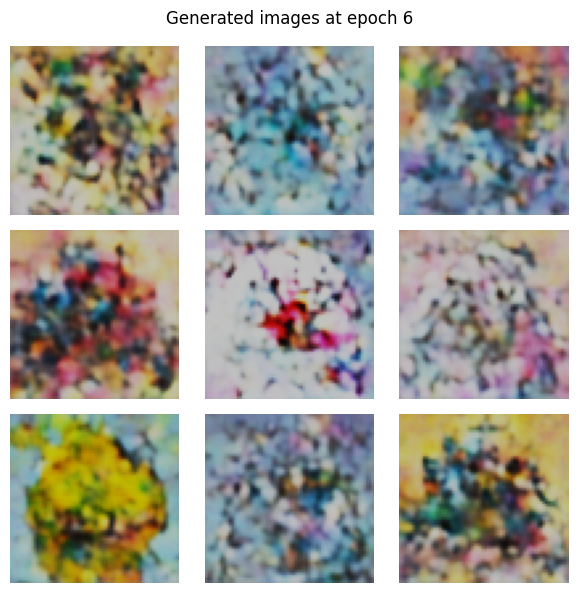

Epoch 6, Generator Loss: 1.0938200950622559, fake score: 0.37787375301122667, Discriminator Loss: 0.9921618700027466, real score: 0.6492598205804825
Epoch 7, Generator Loss: 1.119290828704834, fake score: 0.37432827353477477, Discriminator Loss: 0.9913820028305054, real score: 0.6543785721063614
Epoch 8, Generator Loss: 1.128795862197876, fake score: 0.3669395610690117, Discriminator Loss: 1.0145885944366455, real score: 0.6349837690591812
Epoch 9, Generator Loss: 1.1774859428405762, fake score: 0.35930898785591125, Discriminator Loss: 0.9944469332695007, real score: 0.6406437247991562
Epoch 10, Generator Loss: 1.190178394317627, fake score: 0.3555158033967018, Discriminator Loss: 0.9933411478996277, real score: 0.6369854301214218


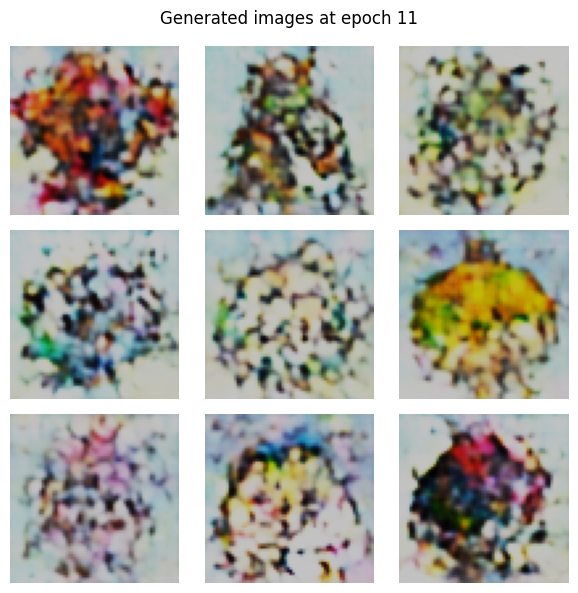

Epoch 11, Generator Loss: 1.2414923906326294, fake score: 0.33977150470018386, Discriminator Loss: 0.9709142446517944, real score: 0.6353905826807023
Epoch 12, Generator Loss: 1.3332650661468506, fake score: 0.3145462676882744, Discriminator Loss: 0.8820154070854187, real score: 0.667160513997078
Epoch 13, Generator Loss: 1.3965749740600586, fake score: 0.3038021430373192, Discriminator Loss: 0.845525860786438, real score: 0.6914856702089309
Epoch 14, Generator Loss: 1.3747810125350952, fake score: 0.31884305477142333, Discriminator Loss: 0.8920093774795532, real score: 0.6899218916893005
Epoch 15, Generator Loss: 1.3289364576339722, fake score: 0.3366396903991699, Discriminator Loss: 0.9542407989501953, real score: 0.6729167431592942


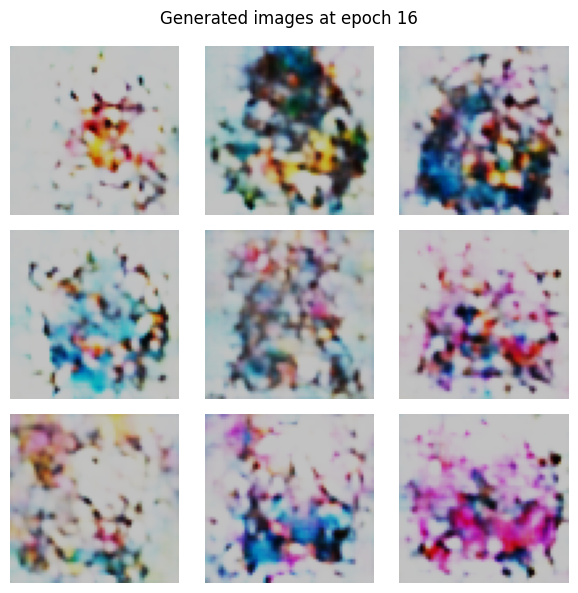

Epoch 16, Generator Loss: 1.3810583353042603, fake score: 0.31420620530843735, Discriminator Loss: 0.8358486294746399, real score: 0.7022717505693435
Epoch 17, Generator Loss: 1.537515640258789, fake score: 0.26919266656041146, Discriminator Loss: 0.689681887626648, real score: 0.7457401037216187
Epoch 18, Generator Loss: 1.5369057655334473, fake score: 0.27359447851777075, Discriminator Loss: 0.6931343078613281, real score: 0.7557278752326966
Epoch 19, Generator Loss: 1.405036211013794, fake score: 0.29929148256778715, Discriminator Loss: 0.7464901208877563, real score: 0.7525572001934051
Epoch 20, Generator Loss: 1.525599479675293, fake score: 0.2672914832830429, Discriminator Loss: 0.6454957127571106, real score: 0.7808224618434906


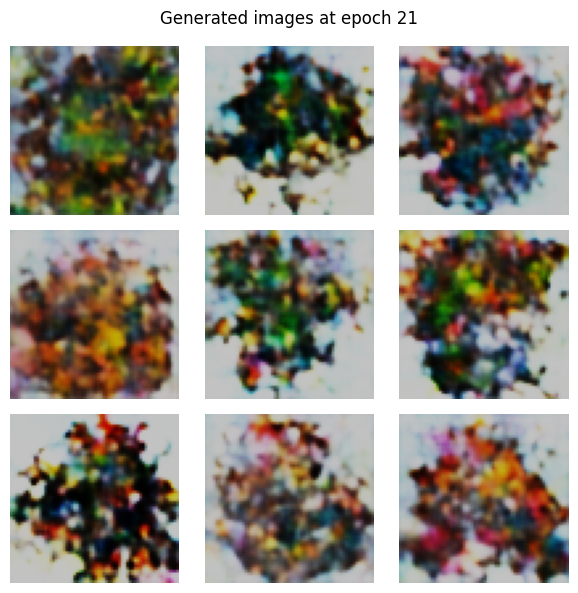

Epoch 21, Generator Loss: 1.6210098266601562, fake score: 0.2607598125934601, Discriminator Loss: 0.6680520176887512, real score: 0.7657546788454056
Epoch 22, Generator Loss: 1.7726001739501953, fake score: 0.2307986795902252, Discriminator Loss: 0.6119081377983093, real score: 0.7687826335430146
Epoch 23, Generator Loss: 1.5985219478607178, fake score: 0.2870529979467392, Discriminator Loss: 0.7823101282119751, real score: 0.7336825042963028
Epoch 24, Generator Loss: 1.3429909944534302, fake score: 0.33276142179965973, Discriminator Loss: 1.0674183368682861, real score: 0.6176748603582383
Epoch 25, Generator Loss: 1.839695692062378, fake score: 0.2206017829477787, Discriminator Loss: 0.654058575630188, real score: 0.7323235273361206


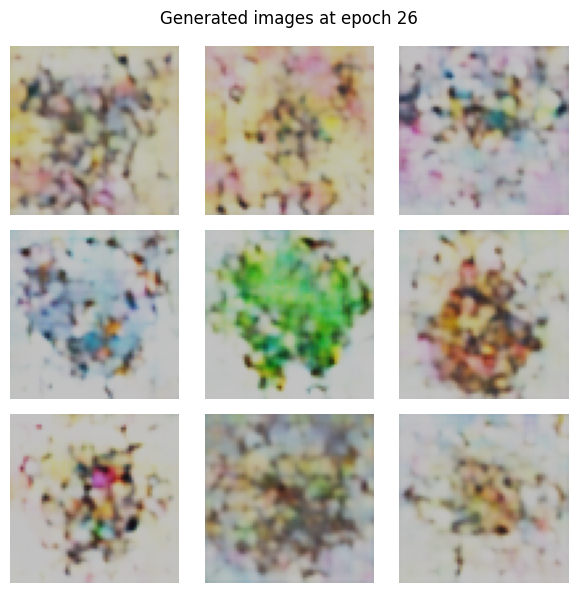

Epoch 26, Generator Loss: 2.314725875854492, fake score: 0.14852786660194398, Discriminator Loss: 0.4050944447517395, real score: 0.8198919236660004
Epoch 27, Generator Loss: 2.146941661834717, fake score: 0.17456374876201153, Discriminator Loss: 0.4812380373477936, real score: 0.7912399411201477
Epoch 28, Generator Loss: 1.5257487297058105, fake score: 0.28537978827953336, Discriminator Loss: 0.7737149596214294, real score: 0.7157423347234726
Epoch 29, Generator Loss: 1.9532968997955322, fake score: 0.21374896243214608, Discriminator Loss: 0.5508006811141968, real score: 0.7943115115165711
Epoch 30, Generator Loss: 2.516441822052002, fake score: 0.13606261424720287, Discriminator Loss: 0.28930893540382385, real score: 0.8971294313669205


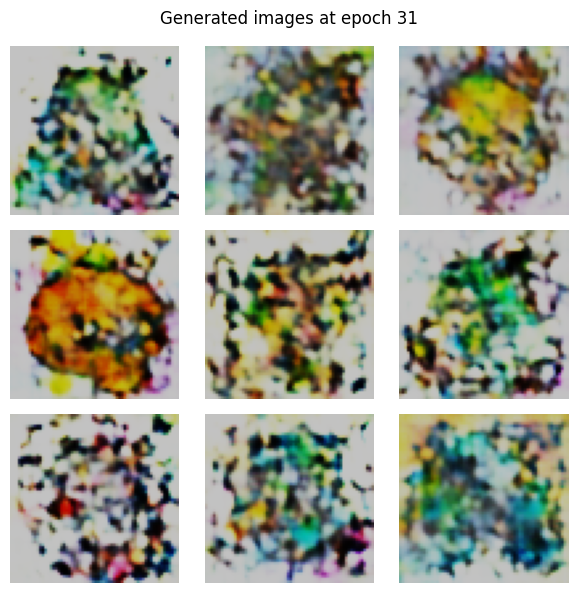

Epoch 31, Generator Loss: 2.3888051509857178, fake score: 0.15356793701648713, Discriminator Loss: 0.32973918318748474, real score: 0.8864313960075378
Epoch 32, Generator Loss: 2.17519474029541, fake score: 0.17499239519238471, Discriminator Loss: 0.3953559994697571, real score: 0.8594907611608505
Epoch 33, Generator Loss: 2.06826114654541, fake score: 0.1907365195453167, Discriminator Loss: 0.47071146965026855, real score: 0.824443393945694
Epoch 34, Generator Loss: 2.2103023529052734, fake score: 0.17343730106949806, Discriminator Loss: 0.4623262882232666, real score: 0.8188916385173798
Epoch 35, Generator Loss: 2.092409610748291, fake score: 0.18754141367971897, Discriminator Loss: 0.50433748960495, real score: 0.8037838160991668


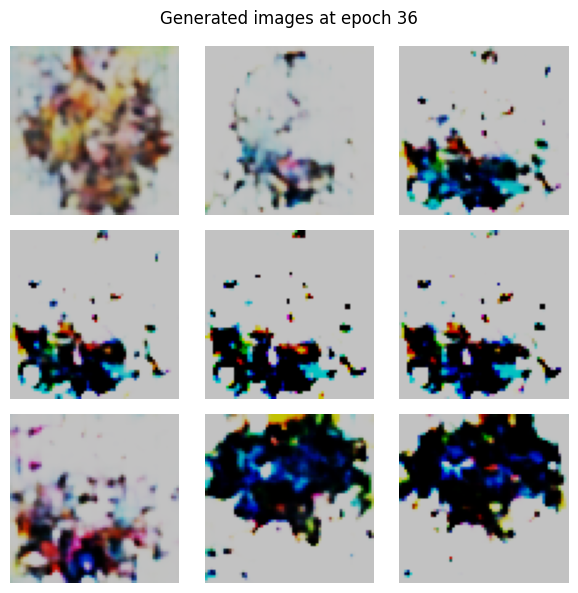

Epoch 36, Generator Loss: 1.610137701034546, fake score: 0.2530143879354, Discriminator Loss: 0.6572635769844055, real score: 0.7637796640396118
Epoch 37, Generator Loss: 2.252880811691284, fake score: 0.1381935551762581, Discriminator Loss: 0.3153872787952423, real score: 0.882529103755951
Epoch 38, Generator Loss: 2.6685309410095215, fake score: 0.09090770613402128, Discriminator Loss: 0.2025676667690277, real score: 0.9173674583435059
Epoch 39, Generator Loss: 4.295364856719971, fake score: 0.01776764839887619, Discriminator Loss: 0.050019245594739914, real score: 0.9723346680402756
Epoch 40, Generator Loss: 5.313734531402588, fake score: 0.005108539294451475, Discriminator Loss: 0.012390794232487679, real score: 0.9931045353412629


In [ ]:
generator_model = generator(decoder)
discriminator_model = discriminator()
train_gan(dataset, generator_model, discriminator_model, epochs=50)